![MLTrain logo](https://mltrain.cc/wp-content/uploads/2017/11/mltrain_logo-4.png "MLTrain logo")

__NB:__ Do not execute the following if running from Databricks!

In [178]:
# !wget -q -O changeNBLayout.py https://raw.githubusercontent.com/cmalliopoulos/PfBDAaML/master/changeNBLayout.py
# !wget -q -O appleStocks.csv https://raw.githubusercontent.com/cmalliopoulos/PfBDAaML/master/appleStocks.csv

%run ../PfBDAaML/changeNBLayout.py

# TL;DR #
High-level Spark APIs (DataFrame, Dataset and SparkSql) are made available through a SparkSession cluster-level object.  
In the following we'll use a SparkSession to construct Spark DataFrames, register them as tables and execute SparkSQL over these tables.  
  
We first do the necessary import. SparkSession lives in the `pyspark.sql` module

In [34]:
import pyspark.sql as pss
from os import linesep as endl

# Dataframe construction and introspection #
A SparkSession is either constructed explicitly from an already avaiable SparkContext of implicitly as below though the `builder` factory method

In [28]:
sses = pss.SparkSession.builder.appName("ssapp01").getOrCreate()

### Create a Spark dataframe from a csv file ###
Notice the schema that read.csv created.  
There's no type info in the text file so everything is parsed as string.  

In [165]:
df = sses.read.csv('appleStocks.csv', header = True)
print type(df)
df.show(n = 10, truncate = True)

print 'df fields and their types:'
df.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
|2010-01-11|21

We can construct a schema explicitly and pass it to the DataFrame

In [187]:
from pyspark.sql.types import StructField, StringType, IntegerType, DateType, FloatType, StructType

dataSchema = [
    StructField("Date", DateType(), nullable = True), 
    StructField("Open", FloatType(), True),
    StructField("Close", FloatType(), True),
    StructField("High", FloatType(), True),
    StructField("Low", FloatType(), True),
    StructField("Volume", IntegerType(), True),
    StructField("Adj Close", StringType(), True)]

dataSchema = StructType(fields = dataSchema)
df = sses.read.csv('appleStocks.csv', schema = dataSchema)

df.printSchema()
df.show(n = 10, truncate = True)

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: string (nullable = true)

+----------+---------+---------+---------+---------+---------+------------------+
|      Date|     Open|    Close|     High|      Low|   Volume|         Adj Close|
+----------+---------+---------+---------+---------+---------+------------------+
|      null|     null|     null|     null|     null|     null|              null|
|2010-01-04|   213.43|    214.5|   212.38|   214.01|123432400|         27.727039|
|2010-01-05|214.59999|   215.59|   213.25|214.37999|150476200|27.774976000000002|
|2010-01-06|214.37999|   215.23|   210.75|   210.97|138040000|27.333178000000004|
|2010-01-07|   211.75|    212.0|   209.05|   210.58|119282800|          27.28265|
|2010-01-08|210.29999|    212.0|   209.06|211.98001|111902700|         27.464034|
|2

In [172]:
# Basic descriptive stats of df's contents
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+-------------------+-----------------+
|summary|              Open|            Close|              High|               Low|             Volume|        Adj Close|
+-------+------------------+-----------------+------------------+------------------+-------------------+-----------------+
|  count|              1762|             1762|              1762|              1762|               1762|             1762|
|   mean|313.07631053340015|315.9112879420788| 309.8282404974289| 312.9270658330668|9.422577587968218E7|75.00174115607275|
| stddev|185.29946731081264|186.8981766989906|183.38391663940038|185.14710364848838|6.020518776592709E7|28.57492972179906|
|    min|              90.0|             90.7|             89.47|             90.28|           11475900|       100.012029|
|    max|            702.41|           705.07|            699.57|         702.10004|          470249500|99.96167700000001|
+-------+-------

# Projections and selections #

Slicing rows and columns of pyspark DataFrames is similar to pandas:  

In [195]:
# import pandas as pd
# df[col.isin(*pd.date_range(dt.datetime(2016, 1, 1), dt.datetime(2016, 2, 1)))].collect()

df[['Date', 'Open']].show(5)

# Selection in pySpark is a relational algebra projection:
df.select(['Open', 'Close']).show(5)

+----------+---------+
|      Date|     Open|
+----------+---------+
|      null|     null|
|2010-01-04|   213.43|
|2010-01-05|214.59999|
|2010-01-06|214.37999|
|2010-01-07|   211.75|
+----------+---------+
only showing top 5 rows

+---------+------+
|     Open| Close|
+---------+------+
|     null|  null|
|   213.43| 214.5|
|214.59999|215.59|
|214.37999|215.23|
|   211.75| 212.0|
+---------+------+
only showing top 5 rows



In [196]:
# Select the volumes of stocks exchanged after 01 Jan 2016
df.filter(df['Date'] > dt.datetime(2016, 1, 1)).select(['Volume']).show(5)

+--------+
|  Volume|
+--------+
|67649400|
|55791000|
|68457400|
|81094400|
|70798000|
+--------+
only showing top 5 rows



# Adding new columns #

We import `month` ufunc from `pyspark.sql.functions` (a great deal of ufuncs are defined there).  
Then create a binned column 'Month' to use it for our aggregations in the sequel

In [216]:
import pyspark.sql.functions as pf

df = df.withColumn('Month', pf.month(df.Date))
df.select('Date', 'Month').sample(False, 0.1).show(5)

+----------+-----+
|      Date|Month|
+----------+-----+
|      null| null|
|2010-01-21|    1|
|2010-01-25|    1|
|2010-02-12|    2|
|2010-02-17|    2|
+----------+-----+
only showing top 5 rows



# Grouping and aggregating #

As in Pandas, the groupby method returns a `groupby` object which we can aggregate on:

In [223]:
applesGroup = df.groupby('Month')

In [226]:
applesGroup.mean('Open').show(2)
applesGroup.max('Open').show(2)
applesGroup.count().show(2)

+-----+------------------+
|Month|         avg(Open)|
+-----+------------------+
|   12|302.76953155722396|
| null|              null|
+-----+------------------+
only showing top 2 rows

+-----+---------+
|Month|max(Open)|
+-----+---------+
|   12|   593.65|
| null|     null|
+-----+---------+
only showing top 2 rows

+-----+-----+
|Month|count|
+-----+-----+
|   12|  149|
| null|    1|
+-----+-----+
only showing top 2 rows



### Simultaneous aggregations ###

In [227]:
applesGroup.agg({'High': 'min', 'Low': 'max', 'Open': 'mean'}).show(5)

+-----+---------+--------+------------------+
|Month|min(High)|max(Low)|         avg(Open)|
+-----+---------+--------+------------------+
|   12|   104.82|  586.19|302.76953155722396|
| null|     null|    null|              null|
|    1|    92.39|  557.36| 322.9062850407192|
|    6|    89.65|  647.35|288.75166641235353|
|    3|    97.42|  617.62| 332.8893473506753|
+-----+---------+--------+------------------+
only showing top 5 rows



## Functions
There are a variety of functions you can import from pyspark.sql.functions.  
Check out the [Spark documentation](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) for the full list available

In [233]:
from pyspark.sql.functions import countDistinct, avg, stddev, year

df.select(countDistinct(year(df.Date))).show()
df.select(avg('Open')).show()
df.select(stddev('Low')).show()

+--------------------------+
|count(DISTINCT year(Date))|
+--------------------------+
|                         7|
+--------------------------+

+------------------+
|         avg(Open)|
+------------------+
|313.07631053340015|
+------------------+

+------------------+
|  stddev_samp(Low)|
+------------------+
|185.14710364848838|
+------------------+



# Exporting to pandas #

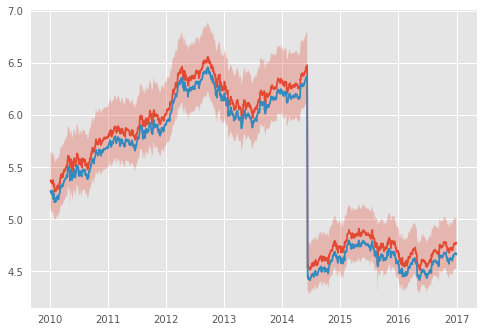

In [152]:
%matplotlib inline

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.width', 144)

pandf = df.toPandas()
pandf['Date'] = pd.to_datetime(pandf['Date'], unit = 'D', errors = 'raise')
pandf = pandf.sort_values(axis = 'index', by = 'Date')

for col in pandf.columns[1:]:
    pandf[col] = pandf[col].astype(float)

# Normalize
pandf.High = pandf.High.map(lambda _: np.log(_ + 1.) * 1.05)
pandf.Low = pandf.Low.map(lambda _: np.log(_ + 1.) * .95)
pandf[['Open', 'Close']] = pandf[['Open', 'Close']].apply(lambda _: np.log(_ + 1.))

with plt.style.context(['ggplot', 'seaborn-notebook']):
    plt.fill_between(x = pandf.Date.values, y1 = pandf.High.values, y2 = pandf.Low.values, alpha = .3)
    plt.plot(pandf.Date.values, pandf.Open.values, pandf.Date.values, pandf.Close.values - .1)

# Required for plotting in Databricks
display()


# The SQL API #

the pySpark SQL API is handy (and intuitive for those who know SQL, however still lacks the capabilities of the Dataframe API in terms of transformations.  
As a general guideline you should use the Dataframe API to transform data, then the SQL API to do aggregations and filtering.  
  
To use SQL queries with a Dataframe object, you will need to register it to a temporary view:

In [217]:
df.createOrReplaceTempView('appleStocksTmpView')

In [221]:
sses.sql('select month, sum(Open) from appleStocksTmpView where High > 500 group by month').show()

+-----+------------------+
|month|         sum(Open)|
+-----+------------------+
|   12|   22440.330078125|
|    1|15079.500122070312|
|    6|15263.839782714844|
|    3|23896.339965820312|
|    5|25074.609924316406|
|    9|13465.249908447266|
|    4|23533.869995117188|
|    8| 16773.52996826172|
|    7|12591.809936523438|
|   10|18641.420135498047|
|   11|   22372.169921875|
|    2| 14139.39990234375|
+-----+------------------+

